# Project description

This file represents a working code related to project related to EdOnline working log analysis with the goal of using log information for building predictive model for student performance.

All the analysis steps are done with Python libraries and are split in the sections below. Detailed explanations are in the report which is based on this code.

# Loading of dataset and general information

File has more than 1.5 Mio lines, so I will read only 1000 first rows to understand the structure of the log file and display first and last 10 rows:

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/train.csv', nrows= 1000)
df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [2]:
df.tail(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
990,990,15092138680,13134,1454,0,295,1,1,29333.0,True
991,991,15092244512,13134,12421,0,296,0,1,30333.0,True
992,992,15092244512,13134,12420,0,296,2,1,30333.0,True
993,993,15092244512,13134,12422,0,296,1,1,30333.0,True
994,994,15092368574,13134,2332,0,297,1,1,22333.0,True
995,995,15092368574,13134,2334,0,297,3,0,22333.0,True
996,996,15092368574,13134,2333,0,297,0,0,22333.0,True
997,997,15092493419,13134,2182,0,298,3,0,31666.0,True
998,998,15092493419,13134,2184,0,298,0,1,31666.0,True
999,999,15092493419,13134,2183,0,298,1,1,31666.0,True


# Aggregation of log info & ratio calculations

Each row represent a log details of each session. In order to include it to the analysis log info has to be aggregated based on the student id. Log inforamtion includes following data:

**timestamp:** (int64) the time in milliseconds between event and first log from

**user_id**: (int32) Student ID.

**content_id:** (int16) ID code for the user interaction

**content_type_id:** (int8) 0 for question, 1 for lecture.

**task_container_id:** (int16) Id code for the bundle of questions or lectures.

**user_answer:** (int8) student choice for the answer, for lectures -1

**answered_correctly:** (int8) 1 correctly, 0 not correct, -1 for lectures

**prior_question_elapsed_time:** (float32) Time in milliseconds to answer a question

**prior_question_had_explanation:** (bool) Includes True is a student used explanations accompaning the questions and False if not

In [3]:
chunk_size = 10**6
train = pd.read_csv('data/train.csv', sep=',', chunksize = chunk_size)

In [4]:
aggregated_students = pd.DataFrame()
chunk_counter = 0

print("Chunk aggregation started. Wait...")

for chunk in train:
    details = chunk[['user_id',
                     'content_type_id',
                     'answered_correctly',
                     'prior_question_elapsed_time',
                     'content_id',
                     'prior_question_had_explanation',
                     'timestamp',
                     'task_container_id'
                    ]]

    # Step 1: identify unique student IDs and count their total activity on the platform
    details = details.reindex(columns = details.columns.tolist() + ['count'])
    details['tot_activity'] = 1
    details['diffs'] = details.groupby('user_id')['timestamp'].diff()

    unique_st_id = details.groupby('user_id').agg(tot_act = ('tot_activity', 'count'),
                                            n_un_content= ('content_id', 'nunique'),
                                            tot_time = ('timestamp', 'max'),
                                            n_attempt = ('task_container_id', 'nunique'),
                                            time_between = ('diffs', 'mean')
                                            
        
                                            )

    #Step 2. Extract only logs with questions, calcualte correct answers and merge them with students ids
    questions = details[details['content_type_id'] == 0]
    qust_students= questions.groupby('user_id').agg(tot_quest = ('tot_activity', 'count'),
                                                    answ_corr = ('answered_correctly','sum'),
                                                    awg_qu_time = ('prior_question_elapsed_time','mean')
                                                    
                                                    
                                                    
                                                    )
    expl = questions[questions['prior_question_had_explanation'] == True]
    expl_student = expl.groupby('user_id')['prior_question_had_explanation'].count()
    agg_students = pd.merge(unique_st_id, qust_students, how = 'left', on = 'user_id')
    agg_students = pd.merge(agg_students, expl_student, how = 'left', on = 'user_id')

    # Step 3. Extract only logs with lectures, calculate number of different lectures, avg_time
    lectures = details[details['content_type_id'] == 1]
    lect_students  = lectures.groupby('user_id').agg(tot_lect = ('tot_activity', 'count')
                                                                                                                                                   
                                                    )
    # Step 4. Merge all data for ratio calc
    agg_students = pd.merge(agg_students, lect_students, how = 'left', on = 'user_id')
    agg_students = agg_students.fillna(0)
    
    aggregated_students = pd.concat([aggregated_students,agg_students], ignore_index=False)

    chunk_counter+=1
    print(f"Log: agg {chunk_counter} done.")

Chunk aggregation started. Wait...
Log: agg 1 done.
Log: agg 2 done.
Log: agg 3 done.
Log: agg 4 done.
Log: agg 5 done.
Log: agg 6 done.
Log: agg 7 done.
Log: agg 8 done.
Log: agg 9 done.
Log: agg 10 done.
Log: agg 11 done.
Log: agg 12 done.
Log: agg 13 done.
Log: agg 14 done.
Log: agg 15 done.
Log: agg 16 done.
Log: agg 17 done.
Log: agg 18 done.
Log: agg 19 done.
Log: agg 20 done.
Log: agg 21 done.
Log: agg 22 done.
Log: agg 23 done.
Log: agg 24 done.
Log: agg 25 done.
Log: agg 26 done.
Log: agg 27 done.
Log: agg 28 done.
Log: agg 29 done.
Log: agg 30 done.
Log: agg 31 done.
Log: agg 32 done.
Log: agg 33 done.
Log: agg 34 done.
Log: agg 35 done.
Log: agg 36 done.
Log: agg 37 done.
Log: agg 38 done.
Log: agg 39 done.
Log: agg 40 done.
Log: agg 41 done.
Log: agg 42 done.
Log: agg 43 done.
Log: agg 44 done.
Log: agg 45 done.
Log: agg 46 done.
Log: agg 47 done.
Log: agg 48 done.
Log: agg 49 done.
Log: agg 50 done.
Log: agg 51 done.
Log: agg 52 done.
Log: agg 53 done.
Log: agg 54 done.
Lo

In [5]:
# Convert timedeltas from timestamp format to seconds for further analysis
from datetime import datetime
aggregated_students['tot_time_hours'] = (aggregated_students['tot_time'].apply(lambda x: datetime.fromtimestamp(x/1000) - pd.to_datetime('1970-01-01 00:00:00.000')).dt.total_seconds())/3600
aggregated_students['time_between_sec'] = aggregated_students['time_between'].apply(lambda x: datetime.fromtimestamp(x/1000) - pd.to_datetime('1970-01-01 00:00:00.000')).dt.total_seconds()

In [6]:
aggregated_students = aggregated_students.drop(['tot_time', 'time_between'], axis = 'columns')

In [7]:
aggregated_students['pass'] = aggregated_students[['answ_corr', 'tot_quest']].apply(lambda aggregated_students: False if aggregated_students['answ_corr']/aggregated_students['tot_quest'] *100 < 50 else True, axis = 1)

In [8]:
aggregated_students = aggregated_students.reset_index().drop_duplicates(subset='user_id',keep='first').set_index('user_id')

In [9]:
# aggregated data preliminary view
aggregated_students

,tot_act,n_un_content,n_attempt,tot_quest,answ_corr,awg_qu_time,prior_question_had_explanation,tot_lect,tot_time_hours,time_between_sec,pass
user_id,,,,,,,,,,,
115,46,46,42,46,32,19933.311111,6.0,0.0,188.580568,25646.445400,True
124,30,30,16,30,7,18793.000000,0.0,0.0,3.158701,10819.700793,False
2746,20,18,20,19,11,18055.555556,11.0,1.0,3.232071,10843.971421,True
5382,128,123,128,125,84,36048.387097,113.0,3.0,586.764293,27347.649260,True
8623,112,107,100,109,70,26107.407407,96.0,3.0,242.538538,18568.817441,True
...,...,...,...,...,...,...,...,...,...,...,...
2147470770,228,221,214,226,173,23167.382222,195.0,2.0,789.691512,23276.164952,True
2147470777,758,742,482,752,520,20028.103862,721.0,6.0,3706.523668,28412.529991,True
2147481750,50,50,50,50,38,17938.775510,39.0,0.0,18.542991,11941.934041,True


# Ratio calculation

In order to compare students independant of their activity length on the platform all the actitivity details will be transferred to relative ratios not dependant of the total actions on the platform. In this case students lately registered on the platfrom can be compared with those who are working quite a bit already.

Major ratios to be considered in the analysis:

1. Lec_ratio = ralation of total number of lectures 
2. Perforamnce ratio = % of correctly answered questions in total questions attempted by the student
3. Question ratio = % of total questions attempted by the student to the total activities on the platform
4. quest_lect_ratio = % of lectures vs question 
5. expl_ratio = % of the total questions where a student watched an explanation
6. review_ratio = % of activities related to the repeatedly reviewed content in total activities
7. bundle_ratio = % of the activities attempted in bundles to total activities
8. time_between_hours = time between logs
9. activity_ratio = Average time per activity
10. awg_qu_time = average time between attempting question and answering it) 

In [10]:
ratios = pd.DataFrame()

ratios['performance_ratio'] = round(aggregated_students['answ_corr']/aggregated_students['tot_quest'] * 100, 2)
ratios['lect_ratio'] = round(aggregated_students['tot_lect']/aggregated_students['tot_act'] * 100, 2)
ratios['quest_ratio'] = round(aggregated_students['tot_quest']/aggregated_students['tot_act'] * 100,2)
ratios['quest_lect_ratio'] = round(aggregated_students['tot_lect']/aggregated_students['tot_quest'] * 100,2)
ratios['expl_ratio'] = round(aggregated_students['prior_question_had_explanation']/aggregated_students['tot_quest'] * 100,2)
ratios['review_ratio'] = round((aggregated_students['tot_act'] - aggregated_students['n_un_content'])/aggregated_students['tot_act'] *100,2)
ratios['bundle_ratio'] = round((aggregated_students['tot_act'] - aggregated_students['n_attempt'])/aggregated_students['tot_act'] *100,2)
ratios['time_between_hours'] = aggregated_students['time_between_sec']/3600
ratios['activity_ratio'] = aggregated_students['tot_time_hours']/aggregated_students['tot_act']
ratios[['awg_qu_time','pass']] = aggregated_students[['awg_qu_time','pass']]


ratios = ratios.fillna(0)
ratios

,performance_ratio,lect_ratio,quest_ratio,quest_lect_ratio,expl_ratio,review_ratio,bundle_ratio,time_between_hours,activity_ratio,awg_qu_time,pass
user_id,,,,,,,,,,,
115,69.57,0.00,100.00,0.00,13.04,0.00,8.70,7.124013,4.099578,19933.311111,True
124,23.33,0.00,100.00,0.00,0.00,0.00,46.67,3.005472,0.105290,18793.000000,False
2746,57.89,5.00,95.00,5.26,57.89,10.00,0.00,3.012214,0.161604,18055.555556,True
5382,67.20,2.34,97.66,2.40,90.40,3.91,0.00,7.596569,4.584096,36048.387097,True
8623,64.22,2.68,97.32,2.75,88.07,4.46,10.71,5.158005,2.165523,26107.407407,True
...,...,...,...,...,...,...,...,...,...,...,...
2147470770,76.55,0.88,99.12,0.88,86.28,3.07,6.14,6.465601,3.463559,23167.382222,True
2147470777,69.15,0.79,99.21,0.80,95.88,2.11,36.41,7.892369,4.889873,20028.103862,True
2147481750,76.00,0.00,100.00,0.00,78.00,0.00,0.00,3.317204,0.370860,17938.775510,True


In [11]:
final = ratios.groupby('pass').agg(no_students = ('performance_ratio', 'count'),
                                    activity_ratio = ('activity_ratio', 'mean'),
                                    lect_ratio = ('lect_ratio', 'mean'),
                                    quest_ratio = ('quest_ratio', 'mean'),
                                    quest_lect_ratio = ('quest_lect_ratio', 'mean'),
                                    expl_ratio = ('expl_ratio', 'mean'),
                                    review_ratio = ('review_ratio', 'mean'),
                                    bundle_ratio = ('bundle_ratio', 'mean'),
                                    avg_time_bt_logs = ('time_between_hours', 'mean'),
                                    avg_time_qu = ('awg_qu_time', 'mean')
                                          
                                            )
display(final) 

,no_students,activity_ratio,lect_ratio,quest_ratio,quest_lect_ratio,expl_ratio,review_ratio,bundle_ratio,avg_time_bt_logs,avg_time_qu
pass,,,,,,,,,,
False,134439,14.754002,0.580205,99.419795,0.606517,31.478596,2.218618,24.71061,18.308893,23882.293617
True,259217,12.766650,1.145625,98.854375,1.184153,68.140563,5.590997,14.02053,16.039384,23891.703511


# Descriptive Data Analysis & Visulizations

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1200x800 with 0 Axes>

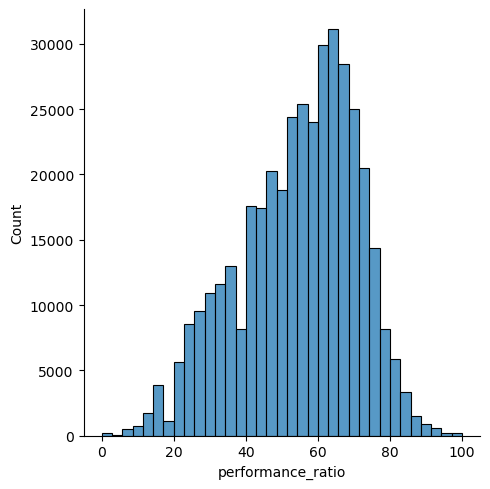

In [13]:
plt.figure(figsize = (12,8))
sns.displot(x = 'performance_ratio', data = ratios, bins = 35);

In [14]:
round(ratios.drop('performance_ratio', axis = 1).describe(),2)

,lect_ratio,quest_ratio,quest_lect_ratio,expl_ratio,review_ratio,bundle_ratio,time_between_hours,activity_ratio,awg_qu_time
count,393656.00,393656.00,393656.00,393656.00,393656.00,393656.00,393656.00,393656.00,393656.00
mean,0.95,99.05,0.99,55.62,4.44,17.67,16.81,13.45,23888.49
std,1.54,1.54,1.62,35.82,8.58,19.07,51.41,47.75,7972.82
min,0.00,58.22,0.00,0.00,0.00,0.00,3.00,0.01,0.00
25%,0.00,98.29,0.00,22.50,0.00,0.00,3.01,0.16,19111.11
50%,0.00,100.00,0.00,63.33,0.00,10.10,4.10,1.13,22721.48
75%,1.71,100.00,1.74,89.66,5.71,35.00,9.67,6.62,27307.69
max,41.78,100.00,71.76,100.00,92.22,78.57,5483.02,2741.51,230833.33


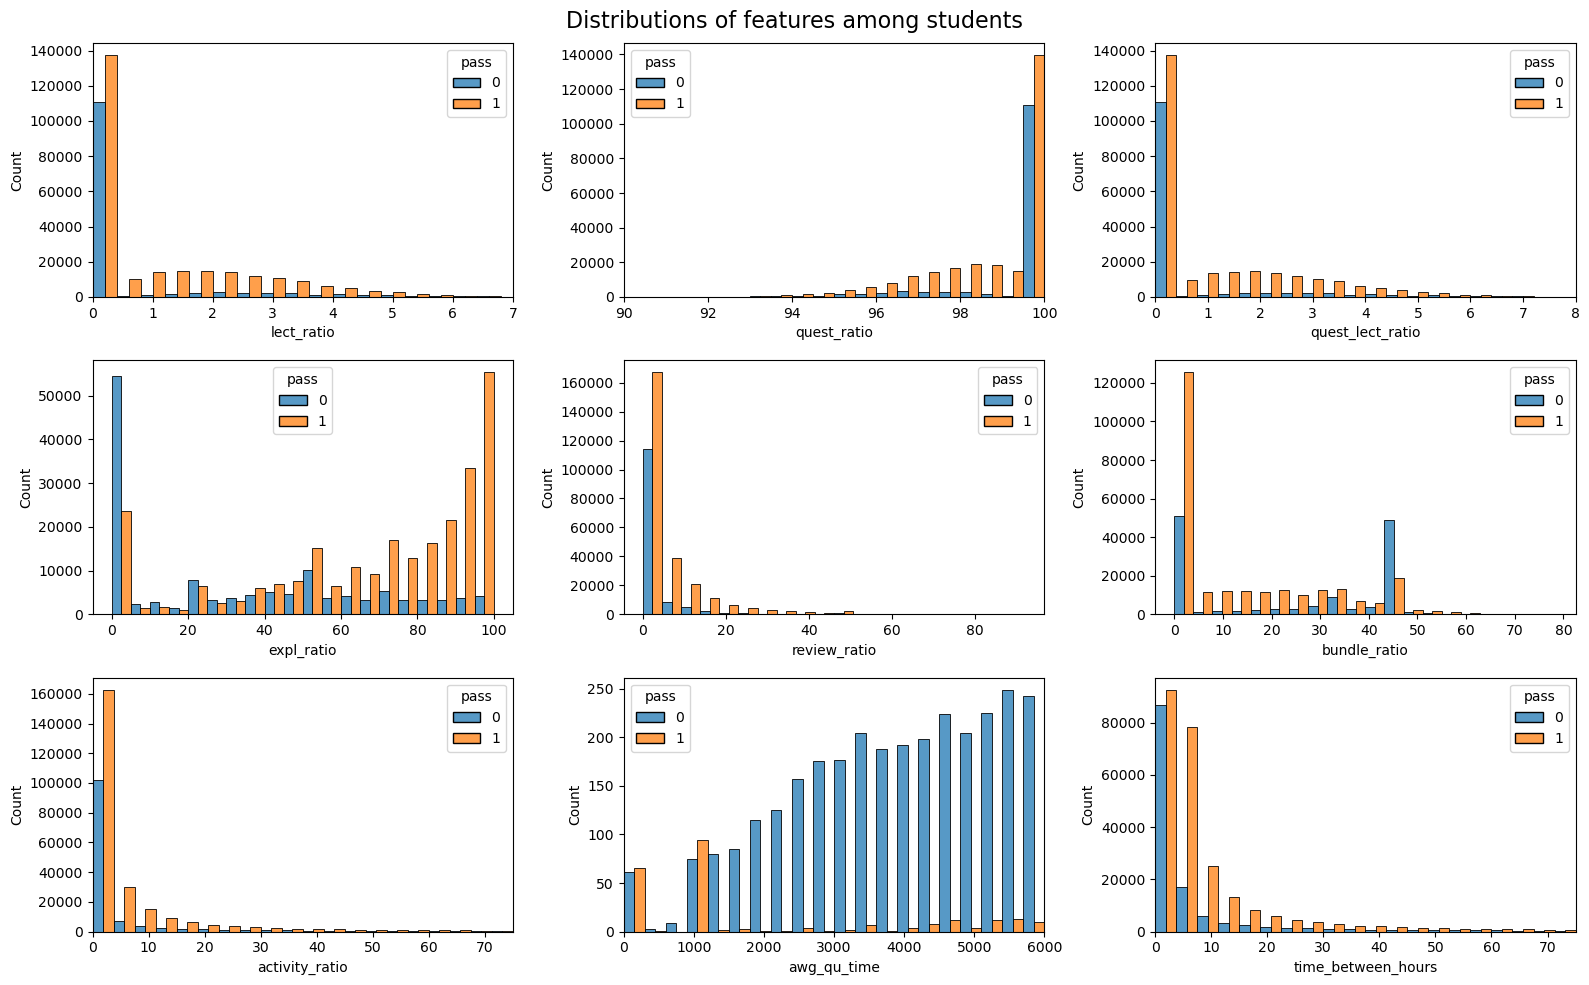

In [15]:
fig, axes = plt.subplots(nrows = 3, ncols= 3, figsize = (16,10))

hue_order = [0,1]

sns.histplot(x = 'lect_ratio', data = ratios, bins = 20, ax = axes[0,0], hue = 'pass', multiple="dodge", hue_order = hue_order, binrange = (0,8))
axes[0,0].set_xlim(0,7)
sns.histplot(x = 'quest_ratio', data = ratios, bins = 20, ax = axes[0,1], hue = 'pass', multiple="dodge", hue_order = hue_order, binrange = (90,100))
axes[0,1].set_xlim(90,100)
sns.histplot(x = 'quest_lect_ratio', data = ratios, bins = 20, ax = axes[0,2], hue = 'pass', multiple="dodge", hue_order = hue_order,binrange = (0,8))
axes[0,2].set_xlim(0,8)
sns.histplot(x = 'expl_ratio', data = ratios, bins = 20, ax = axes[1,0], hue = 'pass', multiple="dodge", hue_order = hue_order)
sns.histplot(x = 'review_ratio', data = ratios, bins = 20, ax = axes[1,1], hue = 'pass', multiple="dodge", hue_order = hue_order)
sns.histplot(x = 'bundle_ratio', data = ratios, bins = 20, ax = axes[1,2], hue = 'pass', multiple="dodge", hue_order = hue_order)
sns.histplot(x = 'activity_ratio', data = ratios, bins = 20, ax = axes[2,0], hue = 'pass', multiple="dodge", hue_order = hue_order, binrange = (0,75))
axes[2,0].set_xlim(0,75)
sns.histplot(x = 'awg_qu_time', data = ratios, bins = 20, ax = axes[2,1], hue = 'pass', multiple="dodge", hue_order = hue_order, binrange = (0,6000))
axes[2,1].set_xlim(0,6000)
sns.histplot(x = 'time_between_hours', data = ratios, bins = 20, ax = axes[2,2], hue = 'pass', multiple="dodge", hue_order = hue_order, binrange = (0,75))
axes[2,2].set_xlim(0,75)
plt.suptitle('Distributions of features among students', fontsize = 16)

plt.tight_layout()

plt.show()

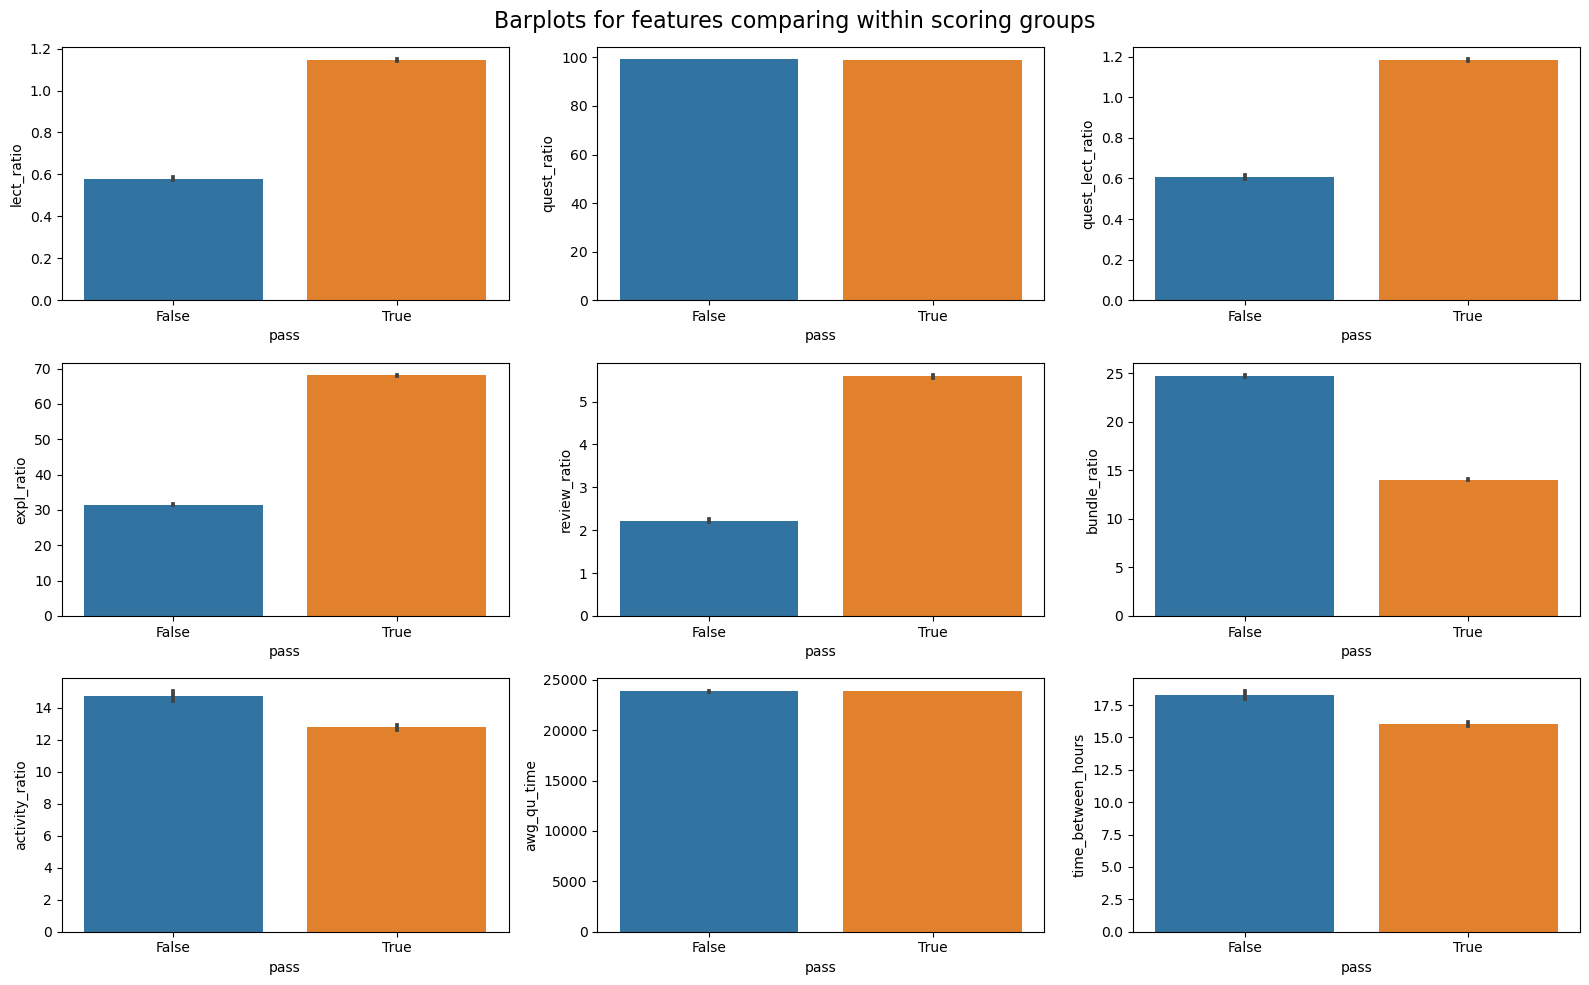

In [16]:
fig, axes = plt.subplots(nrows = 3, ncols= 3, figsize = (16,10))

sns.barplot(y = 'lect_ratio', data = ratios, ax = axes[0,0], x = 'pass')
sns.barplot(y = 'quest_ratio', data = ratios, ax = axes[0,1], x = 'pass')
sns.barplot(y = 'quest_lect_ratio', data = ratios, ax = axes[0,2], x = 'pass')
sns.barplot(y = 'expl_ratio', data = ratios, ax = axes[1,0], x = 'pass')
sns.barplot(y = 'review_ratio', data = ratios, ax = axes[1,1], x = 'pass')
sns.barplot(y = 'bundle_ratio', data = ratios, ax = axes[1,2], x = 'pass')
sns.barplot(y = 'activity_ratio', data = ratios, ax = axes[2,0], x = 'pass')
sns.barplot(y = 'awg_qu_time', data = ratios, ax = axes[2,1], x = 'pass')
sns.barplot(y = 'time_between_hours', data = ratios, ax = axes[2,2], x = 'pass')


plt.suptitle('Barplots for features comparing within scoring groups', fontsize = 16)

plt.tight_layout()

plt.show()

<AxesSubplot:>

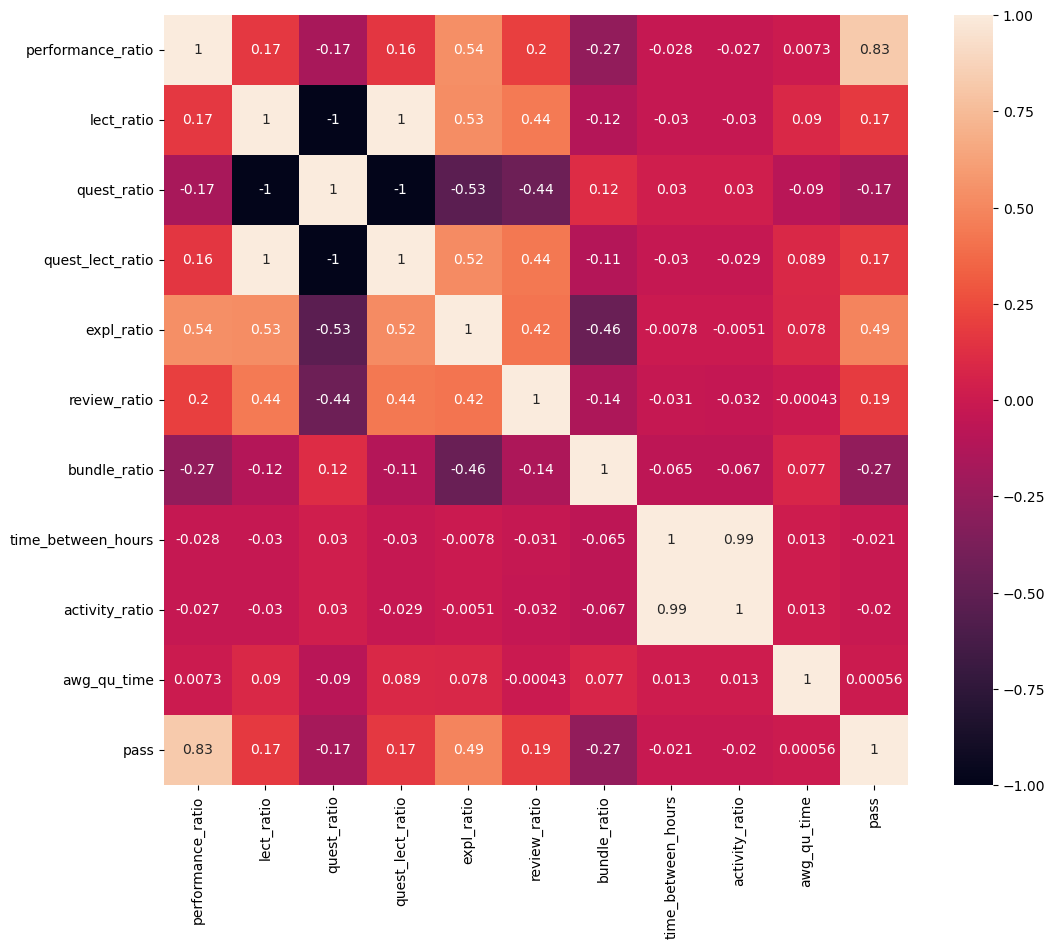

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(ratios.corr(), annot=True)

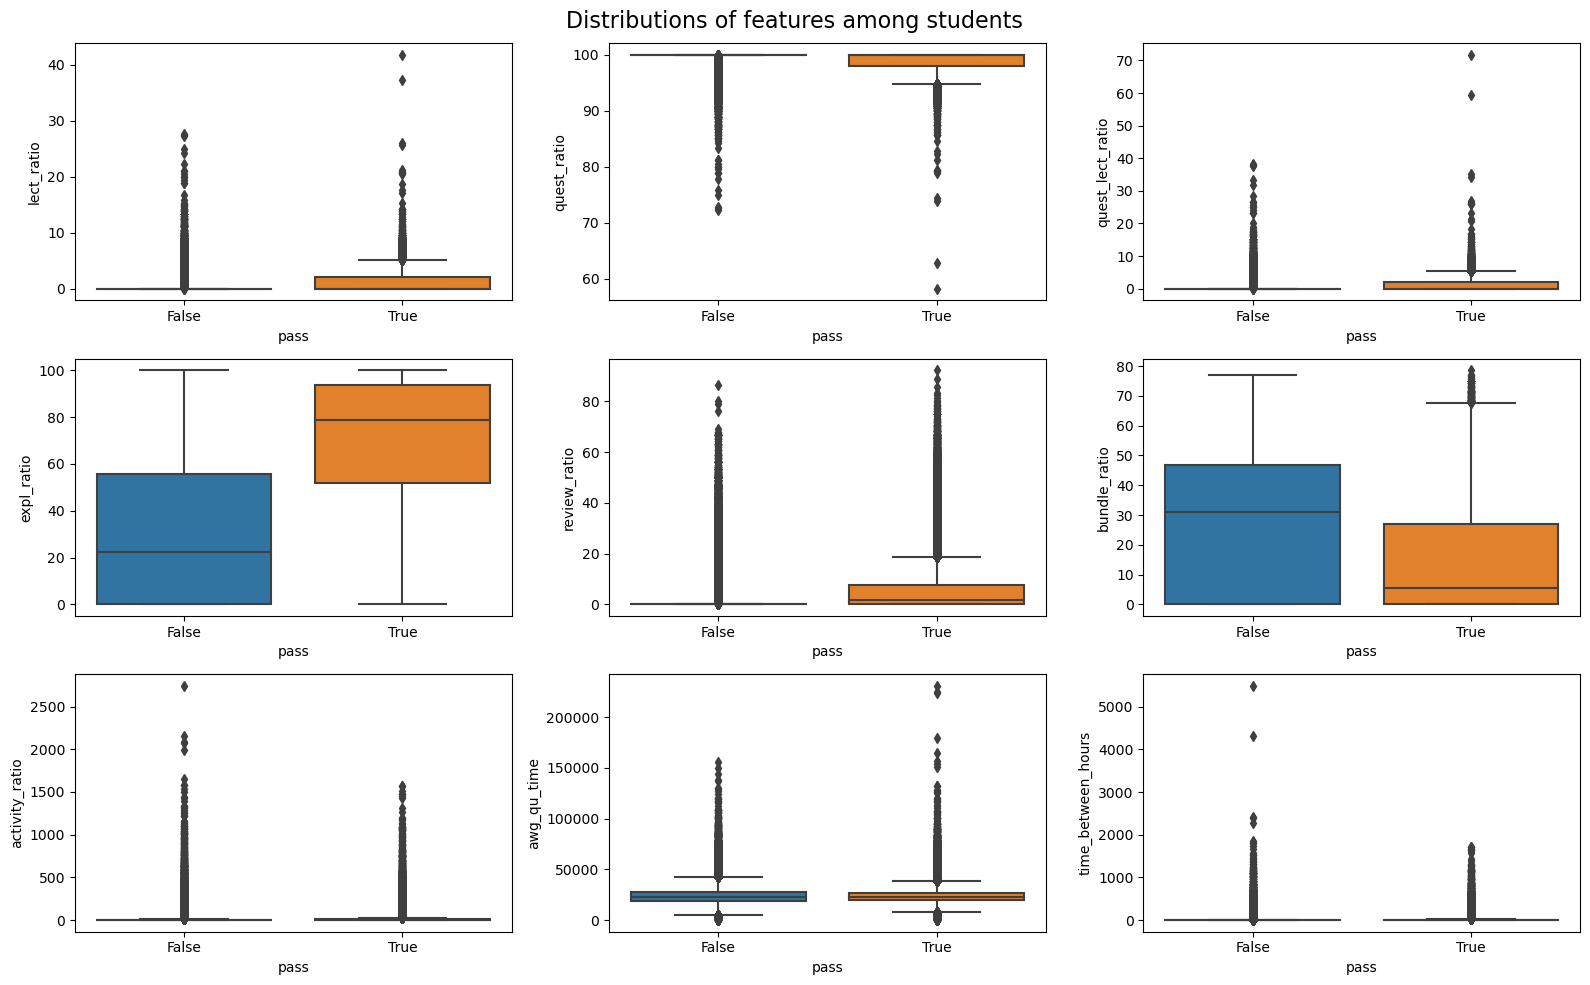

In [18]:
fig, axes = plt.subplots(nrows = 3, ncols= 3, figsize = (16,10))

sns.boxplot(y = 'lect_ratio', data = ratios, ax = axes[0,0], x = 'pass')
sns.boxplot(y = 'quest_ratio', data = ratios, ax = axes[0,1], x = 'pass')
sns.boxplot(y = 'quest_lect_ratio', data = ratios, ax = axes[0,2], x = 'pass')
sns.boxplot(y = 'expl_ratio', data = ratios, ax = axes[1,0], x = 'pass')
sns.boxplot(y = 'review_ratio', data = ratios, ax = axes[1,1], x = 'pass')
sns.boxplot(y = 'bundle_ratio', data = ratios, ax = axes[1,2], x = 'pass')
sns.boxplot(y = 'activity_ratio', data = ratios, ax = axes[2,0], x = 'pass')
sns.boxplot(y = 'awg_qu_time', data = ratios, ax = axes[2,1], x = 'pass')
sns.boxplot(y = 'time_between_hours', data = ratios, ax = axes[2,2], x = 'pass')


plt.suptitle('Distributions of features among students', fontsize = 16)

plt.tight_layout()

plt.show()

In [19]:
ratios.loc[ratios['pass'] == True, 'pass'] = 1
ratios.loc[ratios['pass'] == False, 'pass'] = 0

# Preparation of data set for ML

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

from imblearn.over_sampling import SMOTE, RandomOverSampler

In [21]:
ratios = ratios.reset_index()
ratios

,user_id,performance_ratio,lect_ratio,quest_ratio,quest_lect_ratio,expl_ratio,review_ratio,bundle_ratio,time_between_hours,activity_ratio,awg_qu_time,pass
0,115,69.57,0.00,100.00,0.00,13.04,0.00,8.70,7.124013,4.099578,19933.311111,1
1,124,23.33,0.00,100.00,0.00,0.00,0.00,46.67,3.005472,0.105290,18793.000000,0
2,2746,57.89,5.00,95.00,5.26,57.89,10.00,0.00,3.012214,0.161604,18055.555556,1
3,5382,67.20,2.34,97.66,2.40,90.40,3.91,0.00,7.596569,4.584096,36048.387097,1
4,8623,64.22,2.68,97.32,2.75,88.07,4.46,10.71,5.158005,2.165523,26107.407407,1
...,...,...,...,...,...,...,...,...,...,...,...,...
393651,2147470770,76.55,0.88,99.12,0.88,86.28,3.07,6.14,6.465601,3.463559,23167.382222,1
393652,2147470777,69.15,0.79,99.21,0.80,95.88,2.11,36.41,7.892369,4.889873,20028.103862,1
393653,2147481750,76.00,0.00,100.00,0.00,78.00,0.00,0.00,3.317204,0.370860,17938.775510,1
393654,2147482216,64.36,1.79,98.21,1.82,96.73,6.07,0.00,4.464152,1.469637,19562.043796,1


## Testing based on the initial dataset w/o any changed in its structure

Two train and test datasets will be generated: with Standard Scaler and Robust Scaler for the data with massive outliers
Final results will be compared based on the chosen metrics and recommendations made for further steps



In [22]:
# Split data set for labels and features

y = ratios['pass']
x = ratios.drop(['pass', 'performance_ratio', 'user_id'], axis = 1)
y = y.astype('int')

In [23]:
# Split data for testing and training sete
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13)
print('Size of the training data set is', x_train.shape[0])
print('Size of test data is', x_test.shape[0])
print('Number of variables', x_train.shape[1])

Size of the training data set is 275559
Size of test data is 118097
Number of variables 9


<AxesSubplot:>

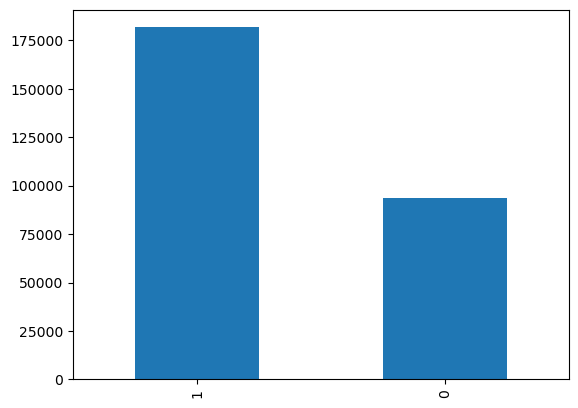

In [24]:
y_train.value_counts().plot(kind = 'bar')

In [25]:
# Usage of standard scaler
scaler = StandardScaler().fit(x_train) 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [26]:
# Usage of robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(x_train) 
x_train1 = scaler.transform(x_train)
x_test1 = scaler.transform(x_test)

In [27]:
np.nan_to_num(x_train, copy = False, nan = 0)
pd.isnull(x_train).sum()

0

In [28]:
np.nan_to_num(x_train1, copy = False, nan = 0)
pd.isnull(x_train).sum()

0

In [29]:
from xgboost import XGBClassifier
names = ['LogisticRegression', 'Gradient_Boosting', 'Decision_Tree','Extra_Trees', 'Random_Forest', 
         'Neural_Net', 'AdaBoost', 'Nearest_Neighbors', 'XGBoost'
        ]

classifiers = [LogisticRegression(), 
               GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
               DecisionTreeClassifier(max_depth=5),
               ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
               RandomForestClassifier(max_depth=5, n_estimators=100),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(n_estimators=100),
               KNeighborsClassifier(3),
               XGBClassifier(n_estimators=600, learning_rate=0.05)
              ]

### Training results with standard scaler

In [30]:
import warnings
warnings.filterwarnings('ignore')
scores = pd.DataFrame()
for name, clf in zip(names, classifiers):
    
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    new_row = {'Test':name, 'Accuracy':round(accuracy_score(y_test, y_pred),4),
               'Precision':round(precision_score(y_test, y_pred),4),
               'Recall': round(recall_score(y_test, y_pred),4),
               'F1 score': round(f1_score(y_test, y_pred),4),
               'ROC-AUC': round(roc_auc_score(y_test,y_pred),4)
              }
    scores = scores.append(new_row, ignore_index=True)
    print('Log: done', name)

scores = scores.set_index('Test')

display(scores.sort_values(by = 'Precision', ascending = False))

Log: done LogisticRegression
Log: done Gradient_Boosting
Log: done Decision_Tree
Log: done Extra_Trees
Log: done Random_Forest
Log: done Neural_Net
Log: done AdaBoost
Log: done Nearest_Neighbors
Log: done XGBoost


,Accuracy,Precision,Recall,F1 score,ROC-AUC
Test,,,,,
XGBoost,0.7728,0.8017,0.8686,0.8338,0.7293
Gradient_Boosting,0.7700,0.8008,0.8645,0.8314,0.7271
Extra_Trees,0.7320,0.7924,0.8017,0.7970,0.7004
Decision_Tree,0.7601,0.7897,0.8646,0.8254,0.7126
AdaBoost,0.7640,0.7894,0.8733,0.8292,0.7143
LogisticRegression,0.7495,0.7826,0.8560,0.8176,0.7011
Neural_Net,0.7617,0.7817,0.8836,0.8295,0.7063
Nearest_Neighbors,0.7281,0.7794,0.8168,0.7976,0.6878
Random_Forest,0.7596,0.7689,0.9061,0.8318,0.6931


### Training results with Robust Scaler speically designed for datasets with heavy outliers

In [31]:
scores2 = pd.DataFrame()
for name, clf in zip(names, classifiers):
    
    clf.fit(x_train1, y_train)
    y_pred = clf.predict(x_test1)
    new_row = {'Test':name, 'Accuracy':round(accuracy_score(y_test, y_pred),4),
               'Precision':round(precision_score(y_test, y_pred),4),
               'Recall': round(recall_score(y_test, y_pred),4),
               'F1 score': round(f1_score(y_test, y_pred),4),
               'ROC-AUC': round(roc_auc_score(y_test,y_pred),4)
              }
    scores2 = scores2.append(new_row, ignore_index=True)
    print('Log: done', name)

scores2 = scores2.set_index('Test')

display(scores2.sort_values(by = 'Precision', ascending = False))

Log: done LogisticRegression
Log: done Gradient_Boosting
Log: done Decision_Tree
Log: done Extra_Trees
Log: done Random_Forest
Log: done Neural_Net
Log: done AdaBoost
Log: done Nearest_Neighbors
Log: done XGBoost


,Accuracy,Precision,Recall,F1 score,ROC-AUC
Test,,,,,
XGBoost,0.7733,0.8019,0.8692,0.8342,0.7297
Gradient_Boosting,0.7691,0.7999,0.8643,0.8308,0.7258
Extra_Trees,0.7329,0.7937,0.8013,0.7974,0.7019
Decision_Tree,0.7600,0.7896,0.8646,0.8254,0.7125
AdaBoost,0.7620,0.7877,0.8722,0.8278,0.7119
LogisticRegression,0.7495,0.7826,0.8560,0.8177,0.7011
Neural_Net,0.7606,0.7812,0.8824,0.8287,0.7053
Nearest_Neighbors,0.7267,0.7777,0.8169,0.7968,0.6857
Random_Forest,0.7591,0.7691,0.9044,0.8313,0.6931


## Testing models on data set balanced artificially standard scaler

<AxesSubplot:>

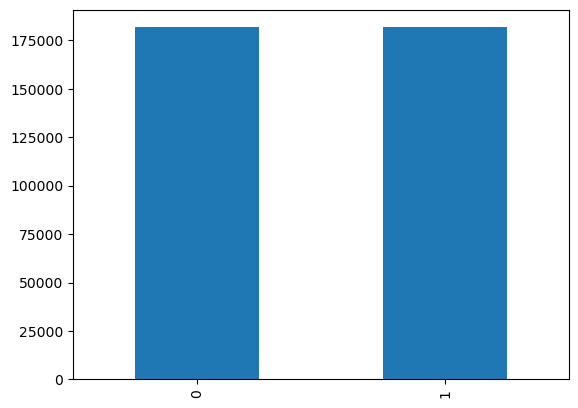

In [32]:
sm =  SMOTE(k_neighbors=5)
x_train2, y_train2 = sm.fit_resample(x_train, y_train)
y_train2.value_counts().plot(kind = 'bar')

In [33]:
scores3 = pd.DataFrame()
for name, clf in zip(names, classifiers):
    
    clf.fit(x_train2, y_train2)
    y_pred = clf.predict(x_test)
    new_row = {'Test':name, 'Accuracy':round(accuracy_score(y_test, y_pred),4),
               'Precision':round(precision_score(y_test, y_pred),4),
               'Recall': round(recall_score(y_test, y_pred),4),
               'F1 score': round(f1_score(y_test, y_pred),4),
               'ROC-AUC': round(roc_auc_score(y_test,y_pred),4)
              }
    scores3 = scores3.append(new_row, ignore_index=True)
    print('Log: done', name)

scores3 = scores3.set_index('Test')

display(scores3.sort_values(by = 'Precision', ascending = False))

Log: done LogisticRegression
Log: done Gradient_Boosting
Log: done Decision_Tree
Log: done Extra_Trees
Log: done Random_Forest
Log: done Neural_Net
Log: done AdaBoost
Log: done Nearest_Neighbors
Log: done XGBoost


,Accuracy,Precision,Recall,F1 score,ROC-AUC
Test,,,,,
XGBoost,0.7493,0.8615,0.7364,0.7940,0.7552
Gradient_Boosting,0.7442,0.8599,0.7289,0.7890,0.7511
AdaBoost,0.7329,0.8586,0.7098,0.7772,0.7434
Random_Forest,0.7284,0.8573,0.7031,0.7725,0.7399
Decision_Tree,0.7309,0.8572,0.7078,0.7754,0.7414
Neural_Net,0.7387,0.8447,0.7374,0.7874,0.7393
LogisticRegression,0.7411,0.8253,0.7679,0.7956,0.7289
Extra_Trees,0.7200,0.8154,0.7409,0.7764,0.7105
Nearest_Neighbors,0.7006,0.8002,0.7245,0.7605,0.6897


## Testing models on data set balanced artificially robust scaler

<AxesSubplot:>

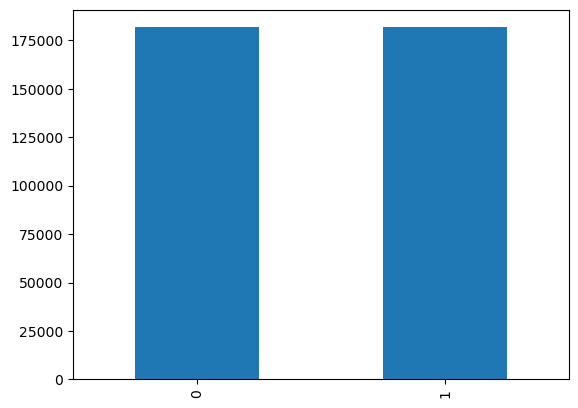

In [34]:
sm =  SMOTE(k_neighbors=5, random_state = 13)
x_train3, y_train3 = sm.fit_resample(x_train1, y_train)
y_train3.value_counts().plot(kind = 'bar')

In [35]:
scores4 = pd.DataFrame()
for name, clf in zip(names, classifiers):
    
    clf.fit(x_train3, y_train3)
    y_pred = clf.predict(x_test1)
    new_row = {'Test':name, 'Accuracy':round(accuracy_score(y_test, y_pred),4),
               'Precision':round(precision_score(y_test, y_pred),4),
               'Recall': round(recall_score(y_test, y_pred),4),
               'F1 score': round(f1_score(y_test, y_pred),4),
               'ROC-AUC': round(roc_auc_score(y_test,y_pred),4)
              }
    scores4 = scores4.append(new_row, ignore_index=True)
    print('Log: done', name)

scores4 = scores4.set_index('Test')

display(scores4.sort_values(by = 'Precision', ascending = False))

Log: done LogisticRegression
Log: done Gradient_Boosting
Log: done Decision_Tree
Log: done Extra_Trees
Log: done Random_Forest
Log: done Neural_Net
Log: done AdaBoost
Log: done Nearest_Neighbors
Log: done XGBoost


,Accuracy,Precision,Recall,F1 score,ROC-AUC
Test,,,,,
Random_Forest,0.7237,0.8616,0.6897,0.7661,0.7391
XGBoost,0.7505,0.8595,0.7407,0.7957,0.7549
Decision_Tree,0.7282,0.8591,0.7006,0.7718,0.7407
Gradient_Boosting,0.7442,0.8571,0.7322,0.7898,0.7497
AdaBoost,0.7377,0.8527,0.7257,0.7841,0.7432
Neural_Net,0.7416,0.8400,0.7488,0.7918,0.7384
LogisticRegression,0.7409,0.8258,0.7669,0.7952,0.7291
Extra_Trees,0.7216,0.8166,0.7425,0.7778,0.7121
Nearest_Neighbors,0.6981,0.7991,0.7211,0.7581,0.6876


### Conclusion what scaler to use in production:

There is no material difference between scalers, so standard scaler will be used for production


# Outliers review



In [36]:
def outliers(data, feature):
    x = data[feature]
    qu_1, qu_3 = x.quantile(0.25), x.quantile(0.75)
    IQR = qu_3 - qu_1
    lower_border = qu_1 - (IQR*1.5)
    upper_border = qu_3 + (IQR*1.5)
    outliers = data[(x<lower_border) | (x>upper_border)]
    return outliers

In [37]:
for column in list(ratios.columns):
    print(column, 'total outliers',len(outliers(ratios, column)), ' or %', round(len(outliers(ratios, column))/ratios.shape[0] *100))

user_id total outliers 0  or % 0
performance_ratio total outliers 589  or % 0
lect_ratio total outliers 18312  or % 5
quest_ratio total outliers 18312  or % 5
quest_lect_ratio total outliers 19535  or % 5
expl_ratio total outliers 0  or % 0
review_ratio total outliers 37000  or % 9
bundle_ratio total outliers 0  or % 0
time_between_hours total outliers 58491  or % 15
activity_ratio total outliers 58772  or % 15
awg_qu_time total outliers 18893  or % 5
pass total outliers 0  or % 0


## Conclusion:

Outliers will be left in the model, no actions required

## Combinded metrics visualization

In [38]:
fin_metric = pd.concat([scores.add_suffix('_StSc'), scores2.add_suffix('_RobSc'), scores3.add_suffix('_StScSMOTE'), scores4.add_suffix('_RobScSMOTE')], axis =1, ignore_index = False)

In [39]:
res = fin_metric[['Precision_StSc', 'Precision_RobSc', 'Precision_StScSMOTE', 'Precision_RobScSMOTE']].sort_values('Precision_StSc', ascending = False)
res

,Precision_StSc,Precision_RobSc,Precision_StScSMOTE,Precision_RobScSMOTE
Test,,,,
XGBoost,0.8017,0.8019,0.8615,0.8595
Gradient_Boosting,0.8008,0.7999,0.8599,0.8571
Extra_Trees,0.7924,0.7937,0.8154,0.8166
Decision_Tree,0.7897,0.7896,0.8572,0.8591
AdaBoost,0.7894,0.7877,0.8586,0.8527
LogisticRegression,0.7826,0.7826,0.8253,0.8258
Neural_Net,0.7817,0.7812,0.8447,0.8400
Nearest_Neighbors,0.7794,0.7777,0.8002,0.7991
Random_Forest,0.7689,0.7691,0.8573,0.8616


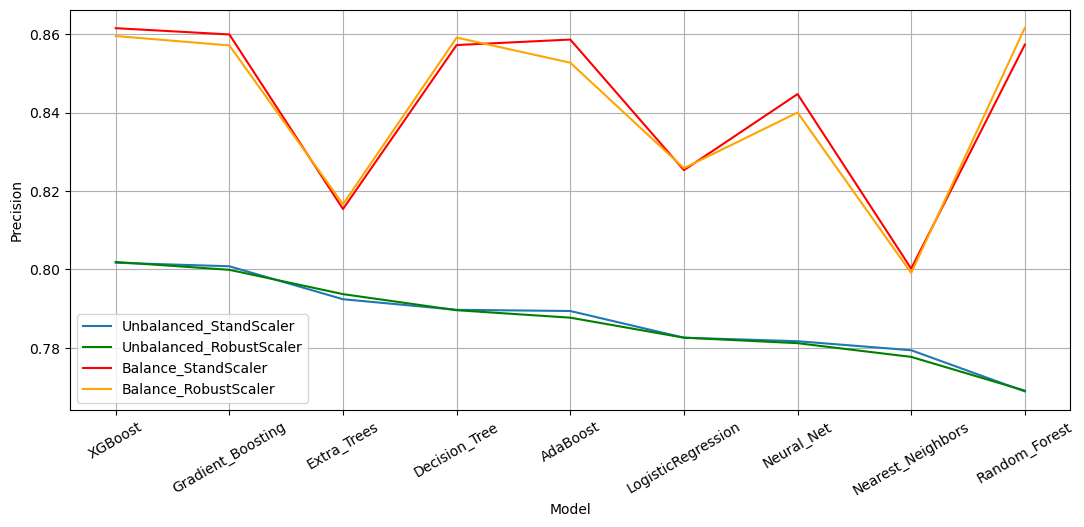

In [40]:
fig =plt.figure(figsize = (10,4))
axes = fig.add_axes ([0,0,1,1])
axes.plot(res['Precision_StSc'],  label = 'Unbalanced_StandScaler')
axes.plot(res['Precision_RobSc'],  label = 'Unbalanced_RobustScaler', c= 'g')
axes.plot(res['Precision_StScSMOTE'],  label = 'Balance_StandScaler', c= 'r')
axes.plot(res['Precision_RobScSMOTE'],  label = 'Balance_RobustScaler', c= 'orange')

axes.set_xlabel('Model')
axes.set_ylabel('Precision')

axes.grid()
axes.legend()
axes.xaxis.set_tick_params(rotation = 30)

In [41]:
res1 = fin_metric[['F1 score_StSc', 'F1 score_RobSc', 'F1 score_StScSMOTE', 'F1 score_RobScSMOTE']].sort_values('F1 score_StSc', ascending = False)
res1

,F1 score_StSc,F1 score_RobSc,F1 score_StScSMOTE,F1 score_RobScSMOTE
Test,,,,
XGBoost,0.8338,0.8342,0.7940,0.7957
Random_Forest,0.8318,0.8313,0.7725,0.7661
Gradient_Boosting,0.8314,0.8308,0.7890,0.7898
Neural_Net,0.8295,0.8287,0.7874,0.7918
AdaBoost,0.8292,0.8278,0.7772,0.7841
Decision_Tree,0.8254,0.8254,0.7754,0.7718
LogisticRegression,0.8176,0.8177,0.7956,0.7952
Nearest_Neighbors,0.7976,0.7968,0.7605,0.7581
Extra_Trees,0.7970,0.7974,0.7764,0.7778


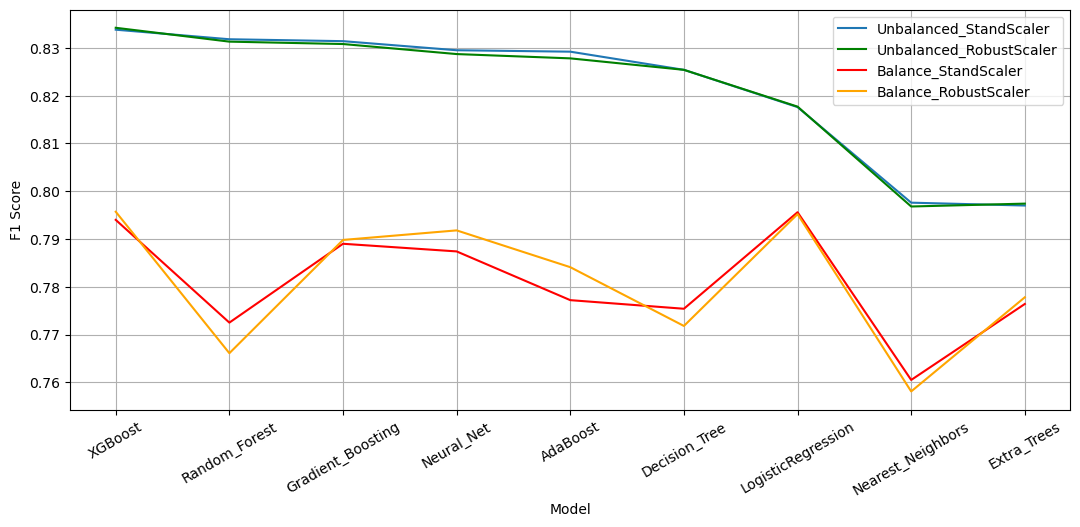

In [42]:
fig =plt.figure(figsize = (10,4))
axes = fig.add_axes ([0,0,1,1])
axes.plot(res1['F1 score_StSc'],  label = 'Unbalanced_StandScaler')
axes.plot(res1['F1 score_RobSc'],  label = 'Unbalanced_RobustScaler', c= 'g')
axes.plot(res1['F1 score_StScSMOTE'],  label = 'Balance_StandScaler', c= 'r')
axes.plot(res1['F1 score_RobScSMOTE'],  label = 'Balance_RobustScaler', c= 'orange')

axes.set_xlabel('Model')
axes.set_ylabel('F1 Score')

axes.grid()
axes.legend()
axes.xaxis.set_tick_params(rotation = 30)

# Upgrading best performing model

In [43]:
from sklearn.model_selection import GridSearchCV
XGBboost = XGBClassifier(learning_rate=0.05)
params = {'n_estimators': [600, 800]} 

grid = GridSearchCV(estimator = XGBboost, param_grid = params, scoring = "average_precision", verbose=True)
grid.fit(x_train2, y_train2)

print(grid.best_score_)
print(grid.best_estimator_.n_estimators)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.8488825174099717
800


In [44]:
XGBboost = XGBClassifier(n_estimators=800)
params = {'learning_rate': [0.01, 0.05, 0.1]} 

grid = GridSearchCV(estimator = XGBboost, param_grid = params, scoring = "average_precision", verbose=True)
grid.fit(x_train2, y_train2)

print(grid.best_score_)
print(grid.best_estimator_.learning_rate)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8519342194538673
0.1


## Cross validation of the finetuned model

In [45]:
from sklearn.model_selection import cross_val_score

XGBoost = XGBClassifier(learning_rate = 0.1, n_estimators = 800)
XGBoost.fit(x_train2, y_train2)
cv_score = cross_val_score(XGBoost, x_train2, y_train2, cv=10, scoring = "average_precision")
display(cv_score)

print("Precision: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))

array([0.83686793, 0.83953297, 0.8363859 , 0.83993188, 0.83954266,
       0.86539232, 0.86945803, 0.87203529, 0.87362992, 0.8710797 ])

Precision: 0.85 (+/- 0.03)


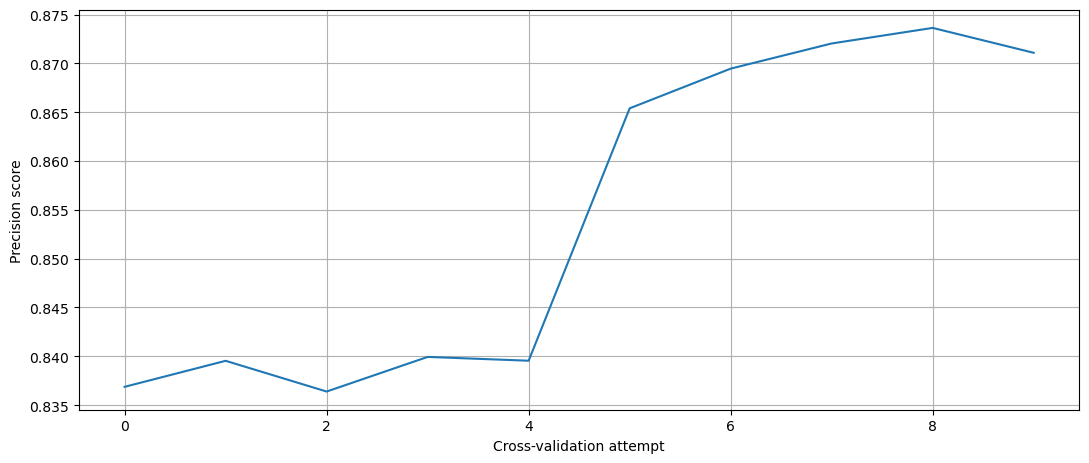

In [46]:
fig =plt.figure(figsize = (10,4))
axes = fig.add_axes ([0,0,1,1])
axes.plot(pd.DataFrame(cv_score))

axes.set_xlabel('Cross-validation attempt')
axes.set_ylabel('Precision score')

axes.grid()


# Feature importance review

<AxesSubplot:>

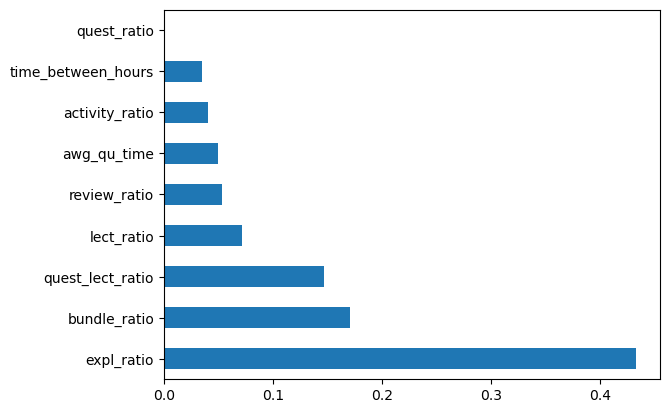

In [47]:
from sklearn.feature_selection import SelectFromModel
fs_xgb=SelectFromModel(XGBClassifier(learning_rate = 0.1, n_estimators = 800)).fit(x_train2, y_train2)
imp_xgb=pd.Series(fs_xgb.estimator_.feature_importances_,index=x.columns).sort_values(ascending=False)
imp_xgb.plot(kind='barh')

# Conclusion

Business question investigated in this study was to understand whether students’ interactions with online platform influence their performance and whether such interactions can be used to predict passing rate and build up an early warning system. It was identified that there are 3 major factors influencing the performance: usage of explanations, listening to more lectures and not bundling test questions. The data from the platform also allows to build up an early warning system as part of the related data mart and make predictions with the average precision of 85%. 
